# US Airline Satisfaction Classification Project  
Mai Nguyen and Emma DePape

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

C:\Users\emmar\anaconda3\envs\data_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read in Data and Preprocessing 
Call the read_csv() function to read in the dataset.

In [2]:
airline = pd.read_csv("https://raw.githubusercontent.com/depapee/DATA3010-finalproject/main/airline_satisfaction.csv")
airline.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,117135,satisfied,Male,disloyal Customer,56,Personal Travel,Eco,369,0,2,...,3,3,1,5,3,3,4,3,0,0.0
1,72091,satisfied,Male,disloyal Customer,49,Personal Travel,Eco,2486,0,2,...,3,2,1,1,4,4,3,2,0,0.0
2,29663,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,1448,0,3,...,3,3,3,5,3,2,3,3,0,0.0
3,81849,satisfied,Female,disloyal Customer,36,Personal Travel,Eco,1501,0,4,...,4,4,5,4,5,5,5,4,0,0.0
4,83693,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,577,0,5,...,3,3,3,4,5,3,4,3,0,0.0


Remove id column because it has no use in the model, it is a random identification integer.

In [3]:
airline = airline.drop(labels="id",axis=1)
airline.head()

,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Male,disloyal Customer,56,Personal Travel,Eco,369,0,2,0,...,3,3,1,5,3,3,4,3,0,0.0
1,satisfied,Male,disloyal Customer,49,Personal Travel,Eco,2486,0,2,1,...,3,2,1,1,4,4,3,2,0,0.0
2,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,1448,0,3,0,...,3,3,3,5,3,2,3,3,0,0.0
3,satisfied,Female,disloyal Customer,36,Personal Travel,Eco,1501,0,4,0,...,4,4,5,4,5,5,5,4,0,0.0
4,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,577,0,5,0,...,3,3,3,4,5,3,4,3,0,0.0


Look to see if there are any missing values in the columns of the dataset.

In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction_v2                    129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

There are missing values in the "Arrival Delay in Minutes" column, we will deal with this by assuming that the customer did not have a delay, therefore did not enter anything, and replace the NA value with zero.

In [5]:
def fill_na_values(colname,x=0):
    airline[colname] = airline[colname].fillna(x)
    
fill_na_values("Arrival Delay in Minutes",0)
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction_v2                    129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

Update column names for clarity sake.

In [6]:
airline = airline.rename(columns = {"satisfaction_v2":"satisfy","Customer Type":"loyalty",
                                    "Type of Travel":"travelPurpose","Flight Distance":"distance",
                                    "Inflight wifi service":"wifiScore","Departure/Arrival time convenient":"scheduleScore",
                                   "Ease of Online booking":"bookingScore","Gate location":"gateScore",
                                    "Food and drink":"foodScore","Online boarding":"boardScore","Seat comfort":"seatScore",
                                   "Inflight entertainment":"entertainScore","On-board service":"onboardScore",
                                   "Leg room service":"legroomScore","Baggage handling":"bagScore",
                                    "Checkin service":"checkinScore","Inflight service":"inflightScore",
                                    "Cleanliness":"cleanScore","Departure Delay in Minutes":"departureDelay",
                                   "Arrival Delay in Minutes":"arrivalDelay"})
airline.head()

,satisfy,Gender,loyalty,Age,travelPurpose,Class,distance,wifiScore,scheduleScore,bookingScore,...,seatScore,entertainScore,onboardScore,legroomScore,bagScore,checkinScore,inflightScore,cleanScore,departureDelay,arrivalDelay
0,satisfied,Male,disloyal Customer,56,Personal Travel,Eco,369,0,2,0,...,3,3,1,5,3,3,4,3,0,0.0
1,satisfied,Male,disloyal Customer,49,Personal Travel,Eco,2486,0,2,1,...,3,2,1,1,4,4,3,2,0,0.0
2,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,1448,0,3,0,...,3,3,3,5,3,2,3,3,0,0.0
3,satisfied,Female,disloyal Customer,36,Personal Travel,Eco,1501,0,4,0,...,4,4,5,4,5,5,5,4,0,0.0
4,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,577,0,5,0,...,3,3,3,4,5,3,4,3,0,0.0


First, we will encode the target variable of 'satisfy' so that it is a binary numeric value for prediction.

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = airline["satisfy"]
airline["satisfy"] = label_encoder.fit_transform(target)

Next, we will look at the correlation matrix to see which features correlate with the satisfy target value the most.

In [8]:
corr_matrix = airline.corr()
corr_matrix["satisfy"].sort_values(ascending=False)

satisfy           1.000000
boardScore        0.501749
entertainScore    0.398234
seatScore         0.348829
onboardScore      0.322205
legroomScore      0.312424
cleanScore        0.307035
distance          0.298085
wifiScore         0.283460
bagScore          0.248680
inflightScore     0.244918
checkinScore      0.237252
foodScore         0.211340
bookingScore      0.168877
Age               0.134091
gateScore        -0.002793
departureDelay   -0.050740
scheduleScore    -0.054270
arrivalDelay     -0.058145
Name: satisfy, dtype: float64

### Create a test set  
Separate the target value from both the test and train sets.

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airline, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

airline = train_set.drop("satisfy", axis=1)
airline_labels = train_set["satisfy"].copy()

valid_X = valid_set.drop("satisfy", axis=1)
valid_y = valid_set["satisfy"].copy()

X_test = test_set.drop("satisfy",axis=1)
y_test = test_set["satisfy"].copy()

### Data Transformation  
Initialize a OneHotEncoder for the categorical variables in the dataset\.  
Initialize a StandardScaler to scale the data for analysis.

In [10]:
airline_cat = airline[["Gender","loyalty","travelPurpose","Class"]]

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

airline_num = airline.select_dtypes(include=[np.number])

std_scaler = StandardScaler()

Initialize a full pipeline to call the encoder and scaler on the training set.

In [12]:
from sklearn.compose import ColumnTransformer

num_attribs = list(airline_num)
cat_attribs = list(airline_cat)

full_pipeline = ColumnTransformer([
        ("num", std_scaler, num_attribs),
        ("cat", cat_encoder, cat_attribs),
    ])

airline_prepared = full_pipeline.fit_transform(airline)

In [13]:
airline_prepared.shape

(83123, 27)

Also call the full_pipeline on the validation set and test set.

In [14]:
X_valid_prepared = full_pipeline.transform(valid_X)

In [15]:
X_test_prepared = full_pipeline.transform(X_test)

## Select and Train a Model

We will try out multiple different model options to select the one that leads to the most accurate classification\.
We will explore:
- Logistic Regression
- SVC
- KNeighbors
- RandomForest
- as well exploring Neural Networks

### Logistic Regression  
We will start with a Logistic Regression model. 

In [16]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(airline_prepared, airline_labels)

LogisticRegression(random_state=42)

In [1]:
from sklearn.model_selection import cross_val_score
cross_val_score(log_reg, airline_prepared, airline_labels, cv=3, scoring="accuracy")

NameError: name 'log_reg' is not defined

### SVC  
Next we will look at a support vector machine classifier.

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="scale", random_state=42)
svm_clf.fit(airline_prepared, airline_labels)

SVC(random_state=42)

In [19]:
cross_val_score(svm_clf, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.9517107 , 0.94979789, 0.94975999])

In [20]:
from sklearn.metrics import accuracy_score

predictions = svm_clf.predict(X_valid_prepared)
accuracy_score(valid_y,predictions)

0.9529859005822626

### KNeighbors  
Next we will explore a KNeighbors classifier.

In [21]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
neigh.fit(airline_prepared,airline_labels)

KNeighborsClassifier()

In [22]:
cross_val_score(neigh, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.92489534, 0.92644724, 0.92474826])

### Random Forest  
Finally we will check out a random forest classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(airline_prepared,airline_labels)

RandomForestClassifier(random_state=42)

In [24]:
cross_val_score(forest_clf, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.96300707, 0.96084163, 0.96029884])

In [25]:
from sklearn.metrics import accuracy_score

predictions = forest_clf.predict(X_valid_prepared)
accuracy_score(valid_y,predictions)

0.9632837688272942

As can be seen from the accuracy scores, our two best options currently are the Support Vector classifier (accuracy $\approx 0.95$) and the Random Forest classifier (accuracy $\approx 0.96$)\.  

## Dimension Reduction
Next, we will look at reducing the dimension in terms of our two best models to see if this increases the accuracy at all\.  
First we will look at PCA for the SVC model.

In [26]:
from sklearn.decomposition import PCA

steps = [('pca', PCA(n_components=10)), ('m', SVC(gamma="scale", random_state=42))]
pca_svc = Pipeline(steps=steps)
pca_svc.fit(airline_prepared,airline_labels)
cross_val_score(pca_svc, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.91518695, 0.91237188, 0.91124986])

This made the accuracy worse but we will still test it out on the Random Forest model as well.

In [27]:
steps = [('pca', PCA(n_components=10)), ('m', RandomForestClassifier(random_state=42))]
pca_forest = Pipeline(steps=steps)
pca_forest.fit(airline_prepared,airline_labels)
cross_val_score(pca_forest, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.908438  , 0.91056735, 0.90699101])

In both cases dimension reduction made our model worse so we will not include it in our final model.

## Precision/Recall and ROC Curves  
We will calculate precision and recall, as well as plot roc curves to further compare the models.

Start by calculating the y scores for the svc model. Then using those scores calculate the precisions, recalls, and thresholds.

In [28]:
from sklearn.model_selection import cross_val_predict

y_scores_svc = cross_val_predict(svm_clf, airline_prepared, airline_labels, cv=3, method="decision_function")

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(airline_labels, y_scores_svc)

In [30]:
from sklearn.metrics import precision_score, recall_score

y_pred_svc = cross_val_predict(svm_clf, airline_prepared, airline_labels, cv=3)
precision_score(airline_labels,y_pred_svc)

0.9542985524557063

In [31]:
recall_score(airline_labels,y_pred_svc)

0.9303021901857499

In [32]:
from sklearn.metrics import f1_score

f1_score(airline_labels, y_pred_svc)

0.9421476001291536

Plot a precision vs recall curve.

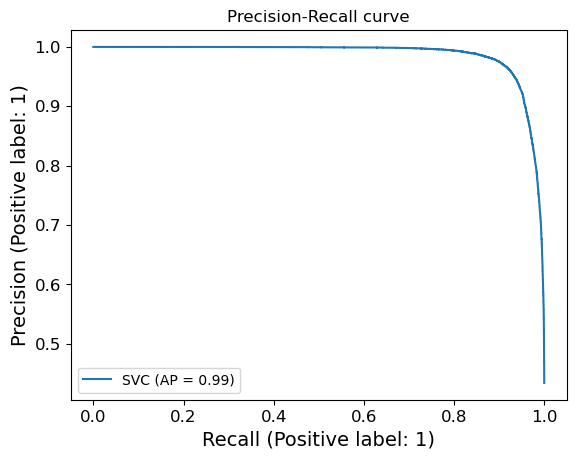

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(airline_labels, y_scores_svc, name="SVC")
_ = display.ax_.set_title("Precision-Recall curve")

Saving figure precision_vs_recall_plot_svc


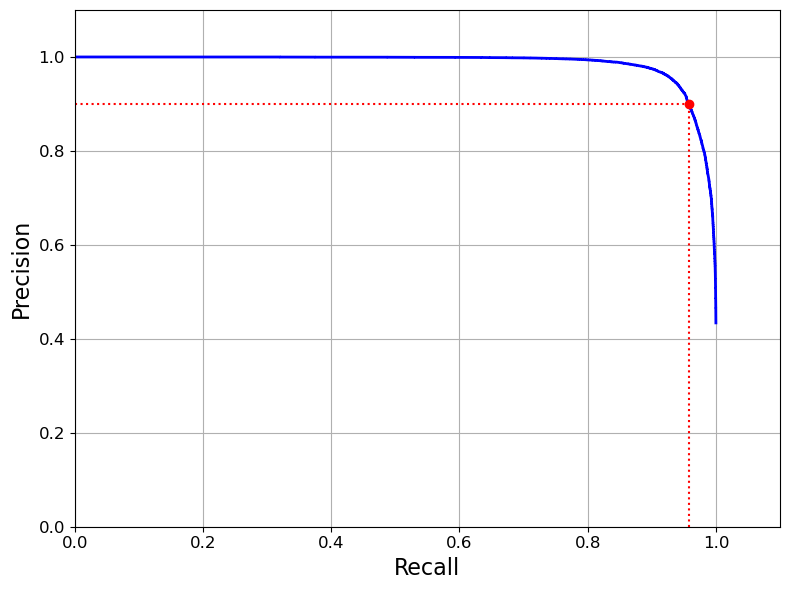

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.1, 0, 1.1])
    plt.grid(True)
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot_svc")
plt.show()

Plot a roc-curve for the svc model. Then, calculate the roc area under the curve.

Saving figure svc_roc_curve


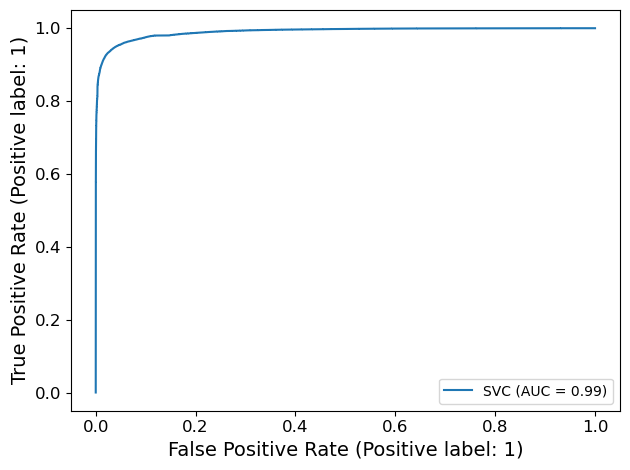

In [35]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(svm_clf, airline_prepared, airline_labels)
save_fig("svc_roc_curve")
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(airline_labels, y_scores_svc)

0.9871578929766691

The SVC model results in a really high area under the curve score of about 0.9872. The model is doing an almost perfect job predicting whether the customer was satisfied or not.

Lets now repeat this process for the Random Forest classifier to see if it does a better job predicting.

In [37]:
y_probas_forest = cross_val_predict(forest_clf, airline_prepared, airline_labels, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
precisions, recalls, thresholds = precision_recall_curve(airline_labels, y_scores_forest)

In [38]:
y_pred_forest = cross_val_predict(forest_clf, airline_prepared, airline_labels, cv=3)
precision_score(airline_labels,y_pred_forest)

0.9700732433051041

In [39]:
recall_score(airline_labels,y_pred_forest)

0.9400055447740504

In [40]:
f1_score(airline_labels, y_pred_forest)

0.9548027371800287

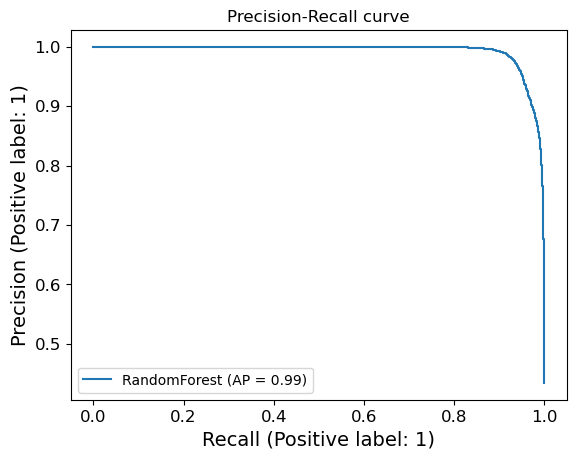

In [41]:
display = PrecisionRecallDisplay.from_predictions(airline_labels, y_scores_forest, name="RandomForest")
_ = display.ax_.set_title("Precision-Recall curve")

Saving figure precision_vs_recall_plot_forest


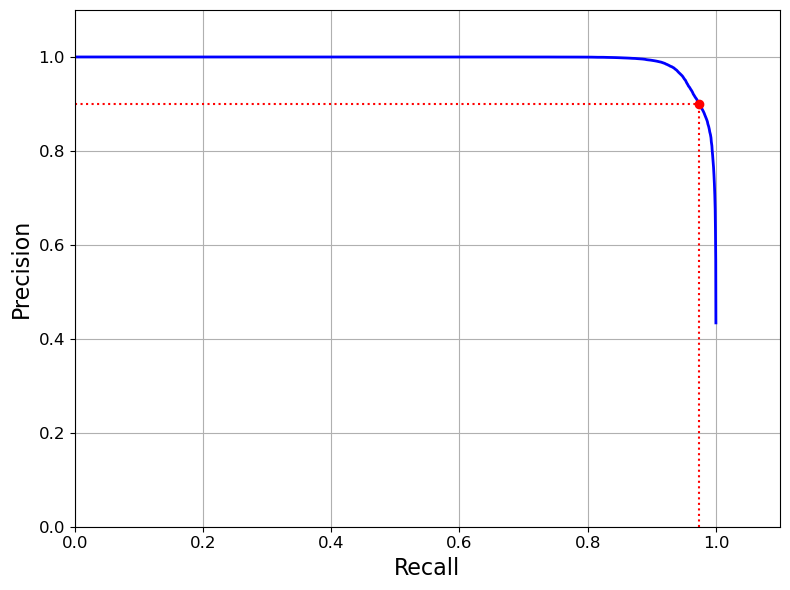

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.1, 0, 1.1])
    plt.grid(True)
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot_forest")
plt.show()

Saving figure forest_roc_curve


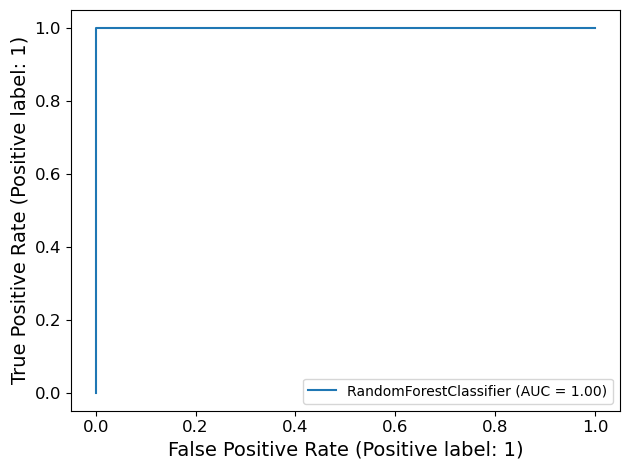

In [43]:
RocCurveDisplay.from_estimator(forest_clf, airline_prepared, airline_labels)
save_fig("forest_roc_curve")
plt.show()

In [44]:
roc_auc_score(airline_labels, y_scores_forest)

0.9935855662082735

The resulting roc area under the curve score is even higher for the Random Forest Classifier, with a score of around 0.9936, it is doing a nearly perfect job classifying the customers.

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(airline_labels, y_scores_svc)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(airline_labels,y_scores_forest)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

Saving figure roc_curve_comparison_plot


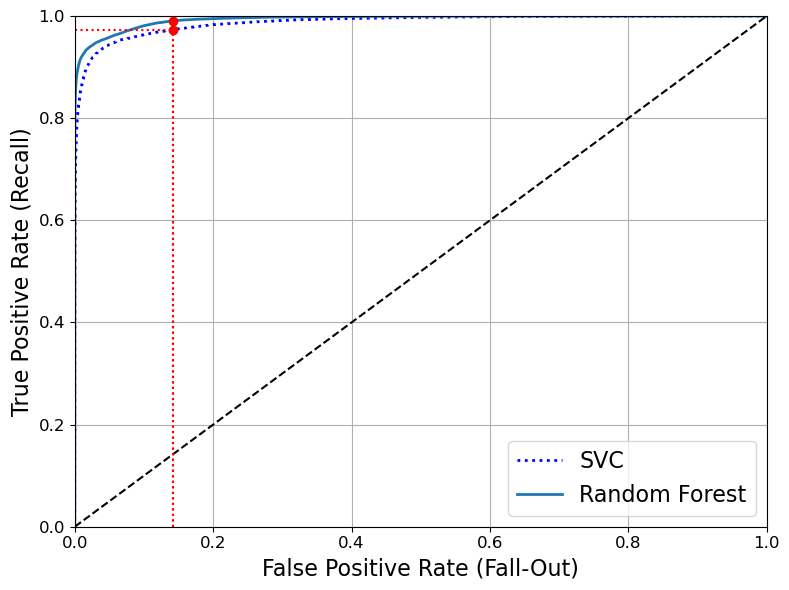

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SVC")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

## Hyper-parameter Tuning of Basic Models

Taking the above results we will preform a grid search on the hyper parameters of the Random Forest Classifier and the Support Vector Classifier to see if we can increase the accuracy of the model\.  
We will start with the random forest.

### Random Forest Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_clf_tune = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf_tune, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=30; total time=   1.4s
[CV] END ....................max_features=2, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [48]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [49]:
grid_search.best_score_

0.9551512656620338

Since the best parameters result of our grid search were the max values in the parameter grid, we will re-run the search with higher values to confirm the best parameters. We will also tune on the max_depth and max_leaf_nodes parameters.

In [50]:
param_grid = [
    {'n_estimators': [30,50,100], 'max_features': [8,12,16], 
     'max_depth': [None,2,4,6], 'max_leaf_nodes': [None,20,30,40]}
  ]
grid_search = GridSearchCV(forest_clf_tune, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=30; total time=   1.0s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=30; total time=   4.9s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=30; total time=   1.4s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=30; total time=   1.4s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=30; total time=   1.4s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=50; total time=   2.4s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=50; total time=   4.6s
[CV] END max_depth=None, max_features=8, max_leaf_nodes=None, n_estimators=50; total time=   2.7s
[CV] END max_depth=None, max_features=8, max_leaf_nodes

[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=20, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=30, n_estimators=30; total time=   0.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=30, n_estimators=30; total time=   0.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=30, n_estimators=30; total time=   0.4s
[CV] END max_depth=None, max_features=12, max_leaf_nodes=30, n_estimators=30; total time=   0.4s
[CV] END max_depth=None, 

[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.6s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.6s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=16, max_leaf_nodes=40, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, ma

[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.1s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.1s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.1s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.1s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.1s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=12, max_leaf_nodes=20, n_

[CV] END max_depth=2, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   0.8s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   0.8s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   0.8s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.2s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.2s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.2s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.2s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.2s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   0.5s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40, n_estimators=50; total time=   0.5s
[CV] END max_depth=2, max_features=16, max_leaf_nodes=40,

[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.1s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.1s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.1s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.1s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.1s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.3s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.3s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.3s
[CV] END max_depth=4, max_features=12, max_leaf_nodes=20, n_estimators=30; total time=   0.3s
[CV] END max_depth=4, max_features=12, max_

[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.7s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.7s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.7s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.7s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.4s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.4s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.4s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.4s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.4s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=40, n_estimators=30; total time=   0.3s
[CV] END max_depth=4, max_features=16, max_leaf_nodes=4

[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=30; total time=   0.4s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.8s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.9s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.8s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.8s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=50; total time=   0.7s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.5s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.5s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.5s
[CV] END max_depth=6, max_features=12, max_leaf_nodes=None, n_estimators=100; total time=   1.5s
[CV] END max_depth=6, max_features=1

[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=30; total time=   0.5s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=30; total time=   0.5s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=30; total time=   0.5s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=30; total time=   0.5s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.9s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.9s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.9s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   0.9s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=50; total time=   1.0s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n_estimators=100; total time=   1.9s
[CV] END max_depth=6, max_features=16, max_leaf_nodes=30, n

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [None, 2, 4, 6],
                          'max_features': [8, 12, 16],
                          'max_leaf_nodes': [None, 20, 30, 40],
                          'n_estimators': [30, 50, 100]}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [51]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 8,
 'max_leaf_nodes': None,
 'n_estimators': 50}

In [52]:
grid_search.best_score_

0.9567873964228386

The best number of estimators turns out to be 50, so we will use this in the final model. 
The max number of features was one of the middle values in the range so we will keep it as 8 features in our final model\.  
As for the max depth and max leaf nodes, the best parameter values were the default values for said parameters thus, we will keep those the same in our final model\.

Turns out the best parameters remained the same so for our final model we will use the following hyper parameter values:
- n_estimators = 50
- max_features = 8
- default values for all other parameters

#### Evaluate Final Random Forest Model

In [53]:
final_forest_model = grid_search.best_estimator_

In [54]:
final_forest_model.fit(airline_prepared, airline_labels)
cross_val_score(final_forest_model, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.96311535, 0.96131081, 0.95954091])

In [55]:
predictions = final_forest_model.predict(X_valid_prepared)
accuracy_score(valid_y,predictions)

0.9642461864202878

In [56]:
y_probas_final = cross_val_predict(final_forest_model, airline_prepared, airline_labels, cv=3, method="predict_proba")
y_scores_final = y_probas_final[:, 1]
roc_auc_score(airline_labels, y_scores_final)

0.9938299263792281

##### Evaluate on the test set.

In [57]:
final_predictions = final_forest_model.predict(X_test_prepared)

accuracy_score(y_test,final_predictions)

0.9634277794887589

In [58]:
y_probas_forest = cross_val_predict(final_forest_model, X_test_prepared, y_test, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
roc_auc_score(y_test,y_scores_forest)

0.9917092544546295

We have a final accuracy of 0.9634 for our random forest model. As well as a ROC AUC of 0.9917.

### SVC Grid Search  
Now will will tune the SVC model to try and increase the accuracy of the classifications.

In [59]:
param_grid = [
    {'kernel': ["linear", "poly", "rbf"], 'C': [1, 5, 10, 50], "gamma": [0.0001, 0.0005, 0.001, 0.005]},
  ]

svm_clf_tune = SVC(random_state=42)
grid_search = GridSearchCV(svm_clf_tune, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=  12.9s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=  12.5s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=  12.7s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=  14.6s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=  14.2s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  14.8s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  13.3s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  13.6s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  12.8s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  13.3s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=  15.6s
[CV] END ......................C=1, gamma=0.000

[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   9.6s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=  10.0s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   8.9s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   9.7s
[CV] END ....................C=5, gamma=0.005, kernel=linear; total time=  35.5s
[CV] END ....................C=5, gamma=0.005, kernel=linear; total time=  33.8s
[CV] END ....................C=5, gamma=0.005, kernel=linear; total time=  32.9s
[CV] END ....................C=5, gamma=0.005, kernel=linear; total time=  34.6s
[CV] END ....................C=5, gamma=0.005, kernel=linear; total time=  34.1s
[CV] END ......................C=5, gamma=0.005, kernel=poly; total time=  11.9s
[CV] END ......................C=5, gamma=0.005, kernel=poly; total time=  11.8s
[CV] END ......................C=5, gamma=0.005, kernel=poly; total time=  12.0s
[CV] END ...................

[CV] END ....................C=50, gamma=0.0005, kernel=poly; total time=  12.3s
[CV] END ....................C=50, gamma=0.0005, kernel=poly; total time=  12.8s
[CV] END .....................C=50, gamma=0.0005, kernel=rbf; total time=   8.3s
[CV] END .....................C=50, gamma=0.0005, kernel=rbf; total time=   8.7s
[CV] END .....................C=50, gamma=0.0005, kernel=rbf; total time=   8.4s
[CV] END .....................C=50, gamma=0.0005, kernel=rbf; total time=   7.7s
[CV] END .....................C=50, gamma=0.0005, kernel=rbf; total time=   7.8s
[CV] END ...................C=50, gamma=0.001, kernel=linear; total time= 3.3min
[CV] END ...................C=50, gamma=0.001, kernel=linear; total time= 3.2min
[CV] END ...................C=50, gamma=0.001, kernel=linear; total time= 3.1min
[CV] END ...................C=50, gamma=0.001, kernel=linear; total time= 3.4min
[CV] END ...................C=50, gamma=0.001, kernel=linear; total time= 3.3min
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [1, 5, 10, 50],
                          'gamma': [0.0001, 0.0005, 0.001, 0.005],
                          'kernel': ['linear', 'poly', 'rbf']}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [60]:
grid_search.best_params_

{'C': 50, 'gamma': 0.005, 'kernel': 'rbf'}

In [61]:
grid_search.best_score_

0.9395599754857642

We will use the rbf kernel but we need to run another search on C and gamma.

In [62]:
param_grid = [
    {'kernel': ["rbf"], 'C': [50,55,60,65], "gamma": ["scale",0.005,0.01,0.05]},
  ]

grid_search = GridSearchCV(svm_clf_tune, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=50, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END ......................C=50, gamma=scale, kernel=rbf; total time=   7.6s
[CV] END ......................C=50, gamma=scale, kernel=rbf; total time=   7.3s
[CV] END ......................C=50, gamma=scale, kernel=rbf; total time=   7.6s
[CV] END ......................C=50, gamma=scale, kernel=rbf; total time=   7.1s
[CV] END ......................C=50, gamma=0.005, kernel=rbf; total time=   5.5s
[CV] END ......................C=50, gamma=0.005, kernel=rbf; total time=   6.5s
[CV] END ......................C=50, gamma=0.005, kernel=rbf; total time=   6.6s
[CV] END ......................C=50, gamma=0.005, kernel=rbf; total time=   5.4s
[CV] END ......................C=50, gamma=0.005, kernel=rbf; total time=   5.5s
[CV] END .......................C=50, gamma=0.01, kernel=rbf; total time=   6.4s
[CV] END .......................C=50, gamma=0.01

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [50, 55, 60, 65],
                          'gamma': ['scale', 0.005, 0.01, 0.05],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [63]:
grid_search.best_params_

{'C': 55, 'gamma': 0.01, 'kernel': 'rbf'}

In [64]:
grid_search.best_score_

0.9440352358569088

Since the results are mid range in our parameter grid we will use these hyper-parameters for our final SVC model. Our final parameters are C equal to 55, gamma equal to 0.01, and a kernel of rbf.

#### Evaluate Final SVC Model

In [65]:
final_svc_model = grid_search.best_estimator_

In [66]:
final_svc_model.fit(airline_prepared, airline_labels)
cross_val_score(final_svc_model, airline_prepared, airline_labels, cv=3, scoring="accuracy")

array([0.95319041, 0.95030316, 0.95022918])

In [67]:
predictions = final_svc_model.predict(X_valid_prepared)
accuracy_score(valid_y,predictions)

0.9526490544247149

In [68]:
y_scores_final = cross_val_predict(final_svc_model, airline_prepared, airline_labels, cv=3, method="decision_function")
roc_auc_score(airline_labels, y_scores_final)

0.9881332431605905

##### Evaluate on the test set.

In [69]:
final_predictions = final_svc_model.predict(X_test_prepared)

accuracy_score(y_test,final_predictions)

0.9542654758238374

In [70]:
y_scores_svc = cross_val_predict(final_svc_model, X_test_prepared, y_test, cv=3, method="decision_function")
roc_auc_score(y_test,y_scores_svc)

0.986002902480661

We have a final accuracy of 0.9542 for our SVC model. This is worse than our random forest model. Thus, random forest is our top runner.

## Neural Network Exploration

Next we will look at some different neural network implementations to see if a more complex model leads to a higher accuracy on our test set.

In [71]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

We start by creating a function that takes inputs for the different hyper-parameters of an ANN. We will use this for grid-searching and hyper-parameter tuning.

In [72]:
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3,activ="relu"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=airline_prepared.shape[1:]))
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation=activ))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])
    return model

We start by testing a base ANN classifier to see an initial accuracy for a neural network model.

In [73]:
from keras.wrappers.scikit_learn import KerasClassifier

classifierModel = KerasClassifier(build_model)

classifierModel.fit(airline_prepared, airline_labels, epochs=20,
              validation_data=(X_valid_prepared, valid_y),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

C:\Users\emmar\AppData\Local\Temp\ipykernel_17936\1642244960.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifierModel = KerasClassifier(build_model)


Epoch 1/20
2598/2598 [==============================] - 9s 3ms/step - loss: 8.3249 - accuracy: 0.4418 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 2/20
2598/2598 [==============================] - 8s 3ms/step - loss: 8.6323 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 3/20
2598/2598 [==============================] - 8s 3ms/step - loss: 8.6323 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 4/20
2598/2598 [==============================] - 9s 3ms/step - loss: 8.6322 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 5/20
2598/2598 [==============================] - 8s 3ms/step - loss: 8.6322 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 6/20
2598/2598 [==============================] - 8s 3ms/step - loss: 8.6322 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy: 0.4345
Epoch 7/20
2598/2598 [==============================] - 8s 3ms/step - loss: 8.6322 - accuracy: 0.4339 - val_loss: 8.6229 - val_accuracy:

The callback for early stopping is met so after eleven epochs we reach an accuracy of 0.4339 on the training set and 0.4345 on the validation set\.  
Now we will do hyper-parameter tuning to try and increase that very low initial accuracy.

In [74]:
param_grid = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": [20,30,40,50],
    "learning_rate": [1e-4, 3e-4, 1e-3, 3e-3],
    "activ": ["relu","sigmoid","tanh"]
}

grid_search = GridSearchCV(classifierModel, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=20; total time=   3.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=20; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=20; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=20; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=0, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, lea

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=2, n_neurons=50; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=2, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=2, n_neurons=50; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=3, n_neurons=20; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=3, n_neurons=20; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=3, n_neurons=20; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0001, n_hidden=3, n_neurons=20; total time=   2.7s

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=50; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=50; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=50; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=1, n_neurons=50; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.0003, n_hidden=2, n_neurons=20; total time=   2.4s

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=40; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=40; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=40; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=50; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=50; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=0, n_neurons=50; total time=   2.1s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=30; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=30; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=40; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=40; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=40; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=40; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.001, n_hidden=3, n_neurons=40; total time=   2.8s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=30; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=30; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=30; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=40; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=2, n_neurons=40; total time=   2.6s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=20; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=30; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=1, n_neurons=3

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=3, n_neurons=50; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0001, n_hidden=3, n_neurons=50; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=0, n_neurons=20; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=0, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=0, n_neurons=20; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=0, n_neurons=20; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=0, n_neurons=2

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=50; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=50; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=50; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=2, n_neurons=50; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.0003, n_hidden=3, n_neurons=2

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=40; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=40; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=40; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=40; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=40; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=50; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.001, n_hidden=1, n_neurons=50; tota

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=30; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=30; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=40; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=40; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=0, n_neurons=40; tota

520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=30; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=sigmoid, learning_rate=0.003, n_hidden=3, n_neurons=30; tota

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=40; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=40; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=50; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=50; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=0, n_neurons=50; total time=   2.1s

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=30; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=40; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=40; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=40; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=40; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=40; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0001, n_hidden=3, n_neurons=50; total time=   2.9s

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=30; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=30; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=30; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=40; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=40; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.0003, n_hidden=2, n_neurons=40; total time=   2.7s

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=20; total time=   2.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=20; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=30; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.001, n_hidden=1, n_neurons=30; total time=   2.5s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=20; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=20; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=20; total time=   2.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=30; total time=   2.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=0, n_neurons=30; total time=   2.1s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=2, n_neurons=50; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=2, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=2, n_neurons=50; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   2.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   3.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=tanh, learning_rate=0.003, n_hidden=3, n_neurons=20; total time=   2.4s
520/52

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001C4319FAC20>,
             param_grid={'activ': ['relu', 'sigmoid', 'tanh'],
                         'learning_rate': [0.0001, 0.0003, 0.001, 0.003],
                         'n_hidden': [0, 1, 2, 3],
                         'n_neurons': [20, 30, 40, 50]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [75]:
grid_search.best_params_

{'activ': 'relu', 'learning_rate': 0.003, 'n_hidden': 3, 'n_neurons': 50}

In [76]:
grid_search.best_score_

0.8527491460650692

The best parameters found are an activation function of 'relu', however all other best parameters were the highest values in their grids. We will run another grid search on higher values to confirm the best parameter values.

In [77]:
param_grid = {
    "n_hidden": [3,4,5,6],
    "n_neurons": [50,60,70,80],
    "learning_rate": [3e-3,1e-2,3e-2],
    "activ": ["relu"]
}
grid_search = GridSearchCV(classifierModel, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True, verbose=2)
grid_search.fit(X_valid_prepared,valid_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=50; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=50; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=50; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=50; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=50; total time=   2.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=3, n_neurons=60; total time=   2.5s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_r

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=5, n_neurons=80; total time=   3.0s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=5, n_neurons=80; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=5, n_neurons=80; total time=   3.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=6, n_neurons=50; total time=   3.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=6, n_neurons=50; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=6, n_neurons=50; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.003, n_hidden=6, n_neurons=50; total time=   3.3s
520/52

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=70; total time=   3.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=80; total time=   3.0s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=80; total time=   3.0s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=80; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=80; total time=   3.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=4, n_neurons=80; total time=   2.9s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=5, n_neurons=50; total time=   2.8s
520/520 [====

520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=50; total time=   3.3s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=50; total time=   3.4s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=60; total time=   3.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=60; total time=   3.0s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=60; total time=   3.0s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=60; total time=   3.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.01, n_hidden=6, n_neurons=60; total time=   3.1s
520/520 [====

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=70; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=70; total time=   3.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=70; total time=   3.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=80; total time=   3.3s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=80; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=80; total time=   2.7s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=3, n_neurons=80; total time=   3.1s
520/520 [====

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=50; total time=   3.4s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=50; total time=   3.2s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=50; total time=   3.1s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=50; total time=   3.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=60; total time=   3.6s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=60; total time=   2.8s
520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=5, n_neurons=60; total time=   3.3s
520/520 [====

520/520 [==============================] - 1s 2ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=70; total time=   3.4s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=70; total time=   3.4s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=70; total time=   4.1s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=70; total time=   3.1s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=70; total time=   3.5s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=80; total time=   3.3s
520/520 [==============================] - 1s 3ms/step
[CV] END activ=relu, learning_rate=0.03, n_hidden=6, n_neurons=80; total time=   3.2s
520/520 [====

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001C4319FAC20>,
             param_grid={'activ': ['relu'],
                         'learning_rate': [0.003, 0.01, 0.03],
                         'n_hidden': [3, 4, 5, 6],
                         'n_neurons': [50, 60, 70, 80]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [78]:
grid_search.best_params_

{'activ': 'relu', 'learning_rate': 0.003, 'n_hidden': 4, 'n_neurons': 70}

In [79]:
grid_search.best_score_

0.8613637884357541

We now have finished hyper-parameter tuning of the ANN model with final values of learning rate equal to 0.003, number of hidden layers equal to 4, and 70 neurons per hidden layer\.  
This results in an accuracy of 0.8613\.  

#### Evaluate Final ANN model

In [87]:
final_ann_model = grid_search.best_estimator_

In [88]:
final_ann_model.fit(airline_prepared, airline_labels)
cross_val_score(final_ann_model, airline_prepared, airline_labels, cv=3, scoring="accuracy")

866/866 [==============================] - 2s 2ms/step


array([0.56871662, 0.8890934 , 0.43436677])

In [89]:
predictions = final_ann_model.predict(X_valid_prepared)
accuracy_score(valid_y,predictions)

650/650 [==============================] - 1s 2ms/step


0.8694961743900679

##### Evaluate on the test set

In [90]:
final_predictions = final_ann_model.predict(X_test_prepared)

accuracy_score(y_test,final_predictions)

812/812 [==============================] - 1s 2ms/step


0.8707268247613181

Our final ANN results in an accuracy of 0.8707, which is worse than both our random forest and SVC models.

## Evaluate Final Model on Test Set

From all our hyper-parameter tuning our best model overall was the Random Forest model. We will now do a final test run of that model on the test set.

In [91]:
from sklearn.metrics import accuracy_score

final_model = final_forest_model

final_predictions = final_model.predict(X_test_prepared)

accuracy_score(y_test,final_predictions)

0.9634277794887589

The final model results in an accuracy of 0.9634 on the test set. It is possible that with more hyper-parameter tuning with narrower margins in the hyper-parameter ranges in the parameter grid we could increase this accuracy. However, it is already pretty high so we are pleased with this level of classification accuracy.

## Summary
The chosen dataset is made up of 24 columns detailing the responses of 129,880 people to an airline satisfaction survey. It contains:
- Demographic information (i.e., age , gender, customer type, reason for travel etc.)
- Flight info (i.e., class, distance, flight time, departure delay, arrival delay) 
- Customer experience rating (i.e., wifi, entertainment, online boarding, food/drink, comfort, onboard service, etc.) 
Our goal is to build a model to correctly classify customer's satisfaction. 

First, we started with preprocessing the dataset. We decided to remove the "id" column since it has no effect on the customer's satisfaction. Some missing values were found in the "Arrival Delay in Minutes" column and we filled them with 0. We also shorten the column names since they were unnecessarily long. We dealt with categorical values in the "satisfy" column by making them binary using LabelEncoder(). The dataset was splitted into train, validation and test sets. Then, we created a pipeline to deal with other categorical values in "Gender", "loyalty", "travelPurpose", "Class" columns using OneHotEncoder() and also scaling the dataset using StandardScaler().

Next, we looked at Logistic Regression, Support Vector classifier (SVC), KNeighbors classifier and Random Forest classifier and compared the accucary scores when fitting the valide set. SVC and Random Forest has the highest accuracy scores of approximately 0.95 and 0.96 respectively. Since these scores are quite high, we thought about overfitting and tried dimension reduction. However, it makes our model in both SVC and Random Forest classifier worse so we decided against it. We plotted Precision-Recall Curve for both classifiers and also ROC AUC. Looking at the ROC AUC graph, Random Forest classifier has a slighter higher AUC. 

We did hyper-parameter tuning for both models using grid search to see if we can increase the accuracy scores. For Random Forest classifier, the best hyper-parameters are n_estimators = 50, max_features = 8 and default values for all other paramters. This results in a final accuracy of 0.9634 and a final ROC AUC of 0.9917. For SVC, the best hyper-parameters are C = 55, gamma = 0.01, kernel = rbf and default values for all other paramters. This results in a final accuracy of 0.9542. Thus, Random Forest is our best model.

Lastly, we looked at a base ANN classifier and received an initial accuracy score of 0.4345 on the validation set. We did hyper-parameter tuning and ended up with the best hyper-parameters: ReLu activation function, learning rate of 0.003, 4 hiddenlayers and 70 neurons per hidden layer. This results in a final accuracy of 0.8707 on the test set which is worse than both Random Forest and SVC. 

In conclusion, our best model for classifying customer's satisfaction with 96.34% accuracy is Random Forest Classifier with hyper-parameters: n_estimators = 50, max_features = 8 and default values for all other paramters.  